<a href="https://colab.research.google.com/github/hawk-in-cloud/AI_LearningNotebook/blob/main/TargetSegmentation/TargetSegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
# 1. 安装依赖库与预训练模型（vit_b）
!pip install torch torchvision opencv-python-headless matplotlib
!pip install git+https://github.com/facebookresearch/segment-anything.git

!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 68.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.2 MB/s eta 0:00:00
ERROR: Operation cancelled by user
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/pip/_internal/cli/base_command.py", line 179, in exc_logging_wrapper
    status = run

In [5]:
# 3. 导入库
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import SamPredictor, sam_model_registry

In [6]:
# 4. 加载模型
sam = sam_model_registry["vit_b"](checkpoint="sam_vit_b_01ec64.pth")
predictor = SamPredictor(sam)


In [7]:
# 5. 上传测试图像到Colab（运行后点击上传按钮）

from google.colab import files
uploaded = files.upload()
image_path = next(iter(uploaded))  # 获取上传文件名

# 下载示例图像（小狗）
# !wget https://github.com/ADlead/Dogs-Cats/blob/master/data/test1/10030.jpg
# image_path = "10030.jpg"

Saving Bubble.png to Bubble.png


In [8]:
# 读取并预处理图像
image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # 转换为RGB格式
predictor.set_image(image)  # SAM需要先编码图像

以下代码为单图片多分割单输出

In [9]:
# 初始化模型和图像
def load_and_setup(image_path, model_type="vit_b", model_path="sam_vit_b_01ec64.pth"):
    sam = sam_model_registry[model_type](checkpoint=model_path)
    predictor = SamPredictor(sam)
    image = cv2.cvtColor(cv2.imread(image_path), cv2.COLOR_BGR2RGB)
    predictor.set_image(image)
    return predictor, image

In [10]:
# 定义多个交互点（示例：分割3个不同物体）
prompts = [
    {"points": [[65, 69]], "labels": [1], "color": (1,0,0)},  # 红色掩码
    {"points": [[285, 244]], "labels": [1], "color": (0,1,0)},  # 绿色掩码
    {"points": [[413, 462]], "labels": [1], "color": (0,0,1)},  # 蓝色掩码
]

In [18]:
from scipy.ndimage import binary_erosion

def multi_segment_plot(image, predictor, prompts, alpha=0.5):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # 收集所有需要显示的点坐标和颜色
    all_points = []

    for i, prompt in enumerate(prompts):
        masks, scores, _ = predictor.predict(
            point_coords=np.array(prompt["points"]),
            point_labels=np.array(prompt["labels"]),
            multimask_output=False
        )
        mask = masks[0].astype(bool)

        # ---- 绘制填充 ----
        rgba_fill = np.zeros((*mask.shape, 4))
        rgba_fill[..., :3] = np.array(prompt["color"]).reshape(1,1,3)
        rgba_fill[..., 3] = mask * alpha
        plt.imshow(rgba_fill)

        # ---- 绘制边框 ----
        eroded = binary_erosion(mask, iterations=1)
        boundary = mask & ~eroded
        rgba_border = np.zeros((*mask.shape, 4))
        rgba_border[boundary] = [1, 1, 1, 1]
        plt.imshow(rgba_border)

        # ---- 收集当前prompt的点击坐标 ----
        # 正确提取points数组（原错误代码）
        current_points = np.array(prompt["points"])  # shape: (n,2)
        all_points.extend(current_points)  # 添加到总列表

    # ---- 统一绘制所有点击点（移出循环） ----
    if len(all_points) > 0:
        # 转换为numpy数组
        points_array = np.array(all_points)
        plt.scatter(
            x=points_array[:, 0],  # 正确获取x坐标
            y=points_array[:, 1],  # 正确获取y坐标
            c='red',
            marker='*',
            s=200,
            edgecolor='white',
            label='Click Points'  # 添加到图例
        )

    # ---- 修正图例作用域问题 ----
    # 使用列表推导式中的局部变量p（原错误代码中的prompt变量泄漏问题）
    legend_handles = [
        plt.Line2D([0], [0], marker='o', color='w',
                   markerfacecolor=p["color"], markersize=10,
                   label=f"Mask {idx+1}")
        for idx, p in enumerate(prompts)
    ]
    # 添加点击点的图例项
    if len(all_points) > 0:
        legend_handles.append(
            plt.Line2D([0], [0], marker='*', color='red', markersize=10,
                       label='Click Points', linestyle='None')
        )

    plt.legend(handles=legend_handles)
    plt.title("Multi-Segment with Background")
    plt.axis('off')
    plt.show()


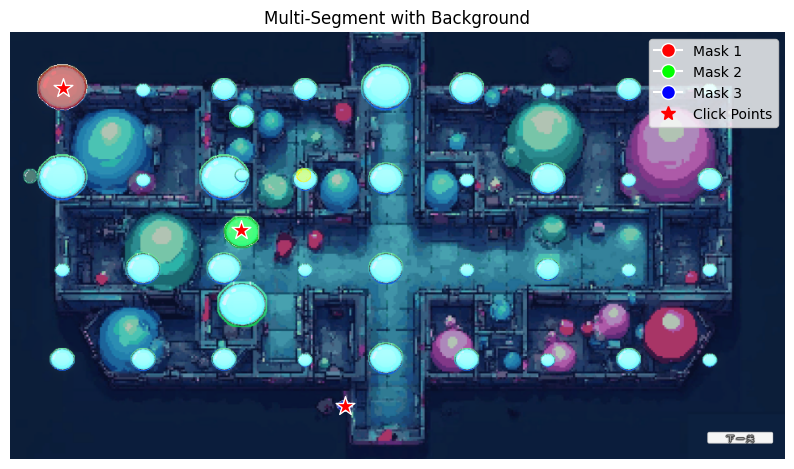

In [19]:
# 执行
# plt.scatter(point_print[:,0], point_print[:,1], color='red', marker='*', s=200, edgecolor='white')  # 显示点击位置
predictor, image = load_and_setup("/content/Bubble.png")
multi_segment_plot(image, predictor, prompts, alpha=0.5)

以下代码为单张图片多次分割

In [6]:
from PIL import Image
import os

def save_mask_as_png(mask, filename, output_dir="masks"):
    """
    将二值掩码保存为PNG文件
    :param mask: 二维numpy数组 (True/False)
    :param filename: 保存文件名（无需后缀）
    :param output_dir: 输出目录
    """
    # 创建输出目录
    os.makedirs(output_dir, exist_ok=True)

    # 转换掩码为0-255图像
    mask_image = (mask * 255).astype(np.uint8)

    # 保存为PNG
    full_path = os.path.join(output_dir, f"{filename}.png")
    Image.fromarray(mask_image).save(full_path)
    print(f"Saved mask to: {full_path}")

Saved mask to: masks/Target1_mask.png.png


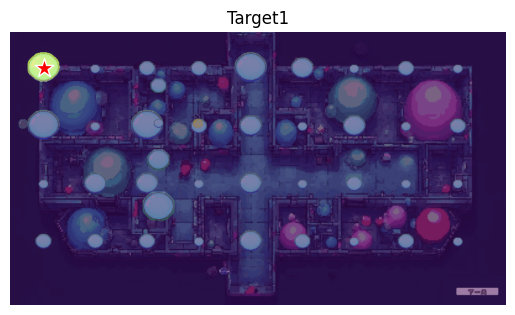

Saved mask to: masks/Target2_mask.png.png


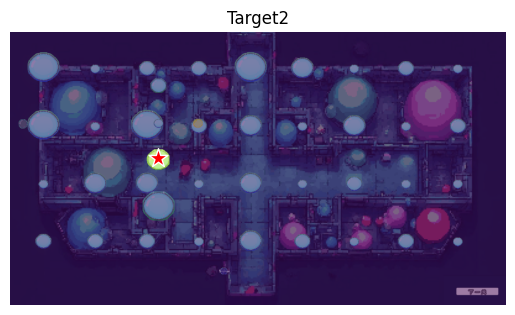

Saved mask to: masks/Target3_mask.png.png


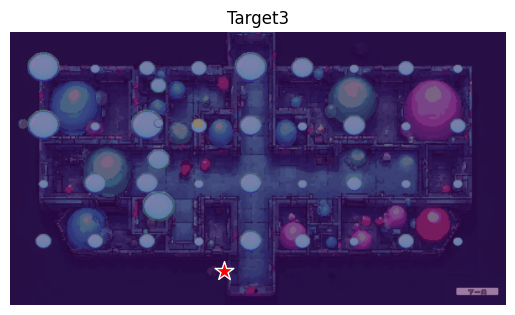

In [8]:
# 定义多个角色的坐标

people_points = [
    [[65, 69], "Target1"],  # 第一目标的坐标和标签
    [[285, 244], "Target2"],  # 第二目标的坐标
    [[413, 462], "Target3"]   # 第三目标的坐标
]

for point, label in people_points:
    masks, scores, _ = predictor.predict(
        point_coords=np.array([point]),
        point_labels=np.array([1]),
        multimask_output=True
    )
    best_mask = masks[np.argmax(scores)]
    # 保存或显示每个分割结果
    save_mask_as_png(best_mask, f"{label}_mask.png")

    # 可视化
    point_print = np.array([point])
    plt.figure()
    plt.imshow(image)
    plt.imshow(best_mask, alpha=0.5)
    plt.scatter(point_print[:,0], point_print[:,1], color='red', marker='*', s=200, edgecolor='white')  # 显示点击位置
    plt.title(label)
    plt.axis('off')
    plt.show()

以下代码为单张图片单次分割

In [ ]:
# 单张图片单次分割

# 7. 定义交互点（示例坐标，需要根据你的图像调整）
# 点击图片查看坐标，例如：小狗的鼻子位置可能是 (500, 300)
input_point = np.array([[350, 113]])  # 格式为[[x,y]]
input_label = np.array([1])  # 1=前景，0=背景

In [ ]:
# 8. 生成分割掩码
masks, scores, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True  # 输出3个候选掩码
)

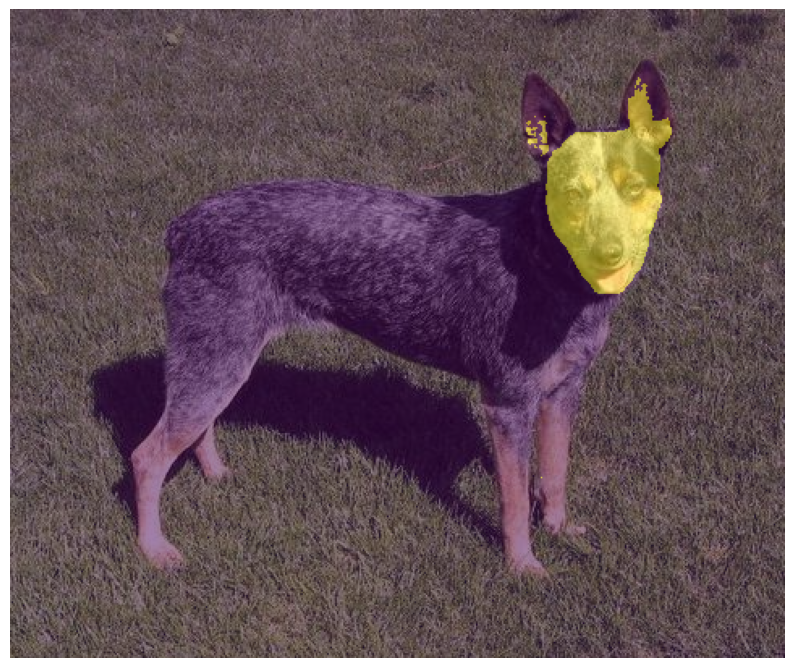

In [ ]:
# 9. 可视化最佳结果
best_mask = masks[scores.argmax()]

plt.figure(figsize=(10,10))
plt.imshow(image)
plt.scatter(input_point[:,0], input_point[:,1], color='red', marker='*', s=200, edgecolor='white')  # 显示点击位置
plt.imshow(best_mask, alpha=0.5)  # 半透明叠加掩码
plt.axis('off')
plt.show()